In [28]:

from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date
import itertools

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json

import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error


### Geting data

In [2]:
df = pd.read_csv("eurofxref-hist.csv")

In [3]:
df1 = df.drop(['CYP','EEK','LTL','LVL','MTL','ROL','SIT','SKK','RUB','TRL', 'BRL', 'JPY','BGN','CZK', 'DKK', 'EEK',
                  'GBP','HUF','ILS','INR','KRW','MXN','MYR','NZD','PHP','SGD', 'THB', 'ZAR','PLN','RON','SEK','CHF','ISK',
                   'NOK','HRK','TRY', 'AUD','CAD','CNY','HKD','IDR'], axis=1)

In [4]:
df1.to_csv('usd_eur.csv', index =False)

In [5]:
usd_eur = pd.read_csv('usd_eur.csv', sep = ',')

### Visualization USD/EUR exchange rate over years which we are going to predict

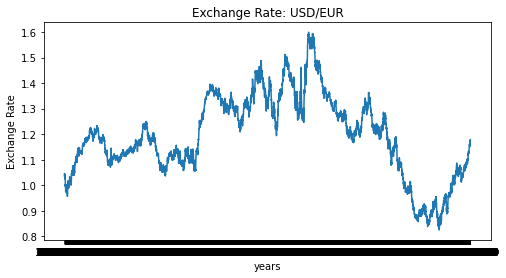

In [6]:
x = usd_eur['Date'].astype(str)
y = usd_eur['USD']

plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.title("Exchange Rate: USD/EUR")
plt.xlabel("years")
plt.ylabel("Exchange Rate")
plt.show()

In [7]:
usd_eur['Date'] = pd.to_datetime(usd_eur['Date'], format = '%d-%m-%Y')
indexed_df = usd_eur.set_index('Date')


In [8]:
usd_eur = indexed_df['USD']
usd_eur.head(5)

Date
2022-11-29    1.0366
2022-11-28    1.0463
2022-11-25    1.0375
2022-11-24    1.0413
2022-11-23    1.0325
Name: USD, dtype: float64

In [9]:
##Visualize the raw data

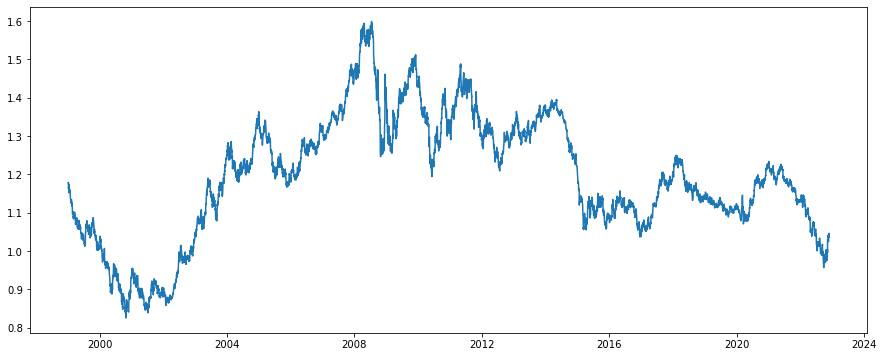

In [10]:
plt.plot(usd_eur.index.to_pydatetime(), usd_eur.values)

In [ ]:
## Resampling the data to avoid to much variation

In [11]:
usd_eur_week = usd_eur.resample('W').mean()

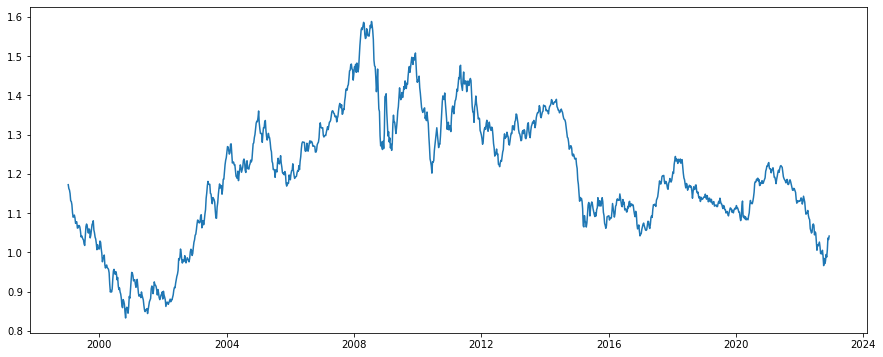

In [12]:
plt.plot(usd_eur_week.index.to_pydatetime(), usd_eur_week.values)

In [13]:
# The observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. 
# The techniques that apply to independent random variables also apply to stationary random variables.
# There are two ways to check the stationarity of a time series. 
# 1.he Dickey-Fuller test
# 2.plot the moving variance and observe if it remains constant over time

In [14]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

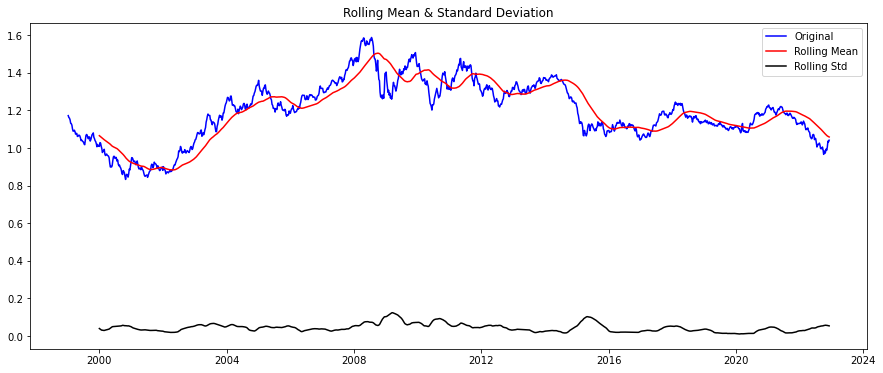

Results of Dickey-Fuller Test:
Test Statistic                   -1.764498
p-value                           0.398224
#Lags Used                        3.000000
Number of Observations Used    1244.000000
Critical Value (1%)              -3.435618
Critical Value (5%)              -2.863866
Critical Value (10%)             -2.568008
dtype: float64


In [15]:
check_stationarity(usd_eur_week)

In [ ]:

# We see that the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected,
# Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05
# It means that we need to transform this time series into a stationary time series before we apply ARIMA Model

## Stationarize the time series

In [ ]:
# First we need to apply a nonlinear log transformation

In [16]:
usd_eur_week_log = np.log(usd_eur_week)

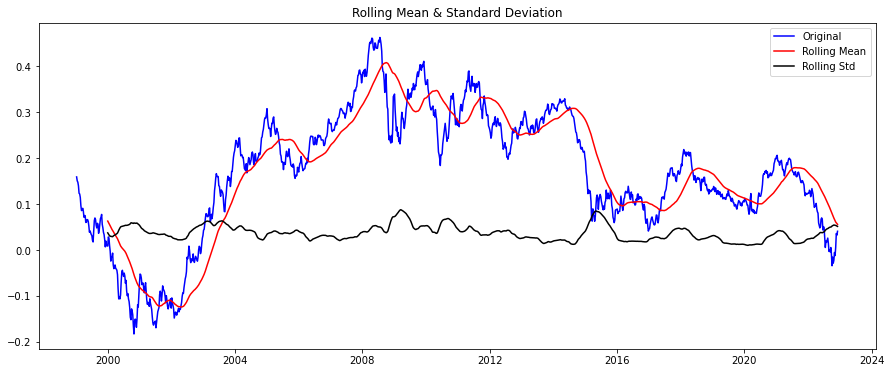

Results of Dickey-Fuller Test:
Test Statistic                   -1.673326
p-value                           0.444905
#Lags Used                        3.000000
Number of Observations Used    1244.000000
Critical Value (1%)              -3.435618
Critical Value (5%)              -2.863866
Critical Value (10%)             -2.568008
dtype: float64


In [17]:
check_stationarity(usd_eur_week_log)

In [ ]:
# So, we see that the series is still non-stationary. 
# Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

## Remove trend and seasonality with decomposition

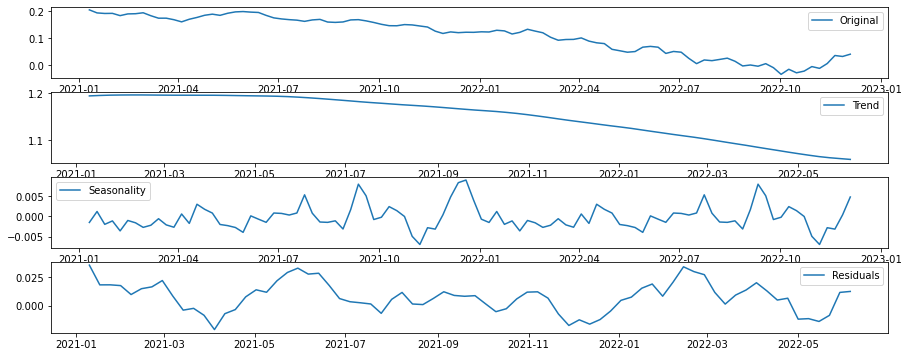

In [18]:
decomposition = seasonal_decompose(usd_eur_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Select the most recent weeks
usd_eur_week_log_select = usd_eur_week_log[-100:]

plt.subplot(411)
plt.plot(usd_eur_week_log_select.index.to_pydatetime(), usd_eur_week_log_select.values, label='Original')

plt.legend(loc='best')
plt.subplot(412)
plt.plot(usd_eur_week_log_select.index.to_pydatetime(), trend[-100:].values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot (usd_eur_week_log_select.index.to_pydatetime(), seasonal[-100:].values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(usd_eur_week_log_select.index.to_pydatetime(), residual[-100:].values, label='Residuals')
plt.legend(loc='best')

## Remove trend and seasonality with differencing

In [ ]:
# After we have stationarized our time series we need to deal with seasonality and trend
# One of the most common methods of dealing with both trend and seasonalityis differencing

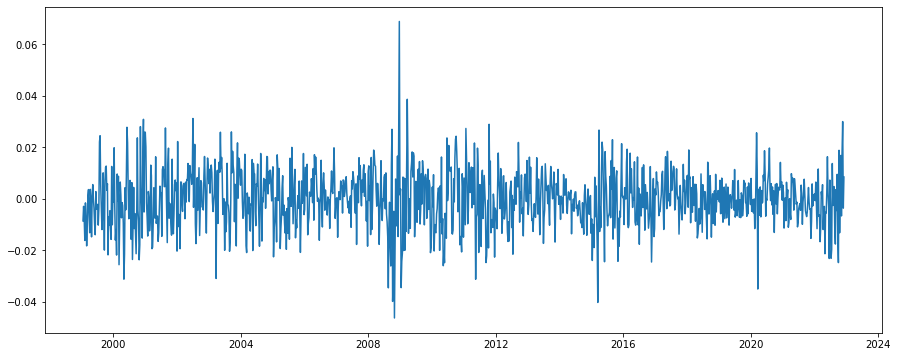

In [19]:
usd_eur_week_log_diff = usd_eur_week_log - usd_eur_week_log.shift()
plt.plot(usd_eur_week_log_diff.index.to_pydatetime(), usd_eur_week_log_diff.values)

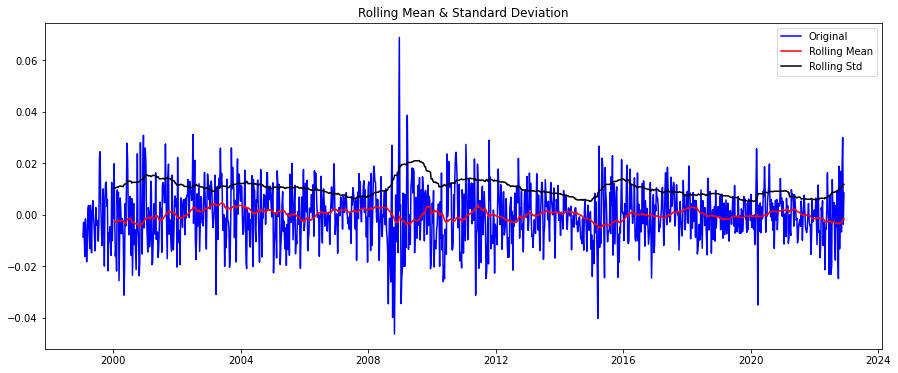

Results of Dickey-Fuller Test:
Test Statistic                -1.829762e+01
p-value                        2.290215e-30
#Lags Used                     2.000000e+00
Number of Observations Used    1.244000e+03
Critical Value (1%)           -3.435618e+00
Critical Value (5%)           -2.863866e+00
Critical Value (10%)          -2.568008e+00
dtype: float64


In [20]:
usd_eur_week_log_diff.dropna(inplace=True)
check_stationarity(usd_eur_week_log_diff)

In [ ]:
# The results show that the test statistic is significantly less than the 1% critical value
# That means that our series now stationary with 99% confidence
# Our data is ready to be used for statistical ARIMA model to forecast future exchange rate for time series

## Looking for optimal parameters and build an ARIMA model

In [ ]:
# ploting the autocorrelation function (ACF) and partial autocorrelation function (PACF)

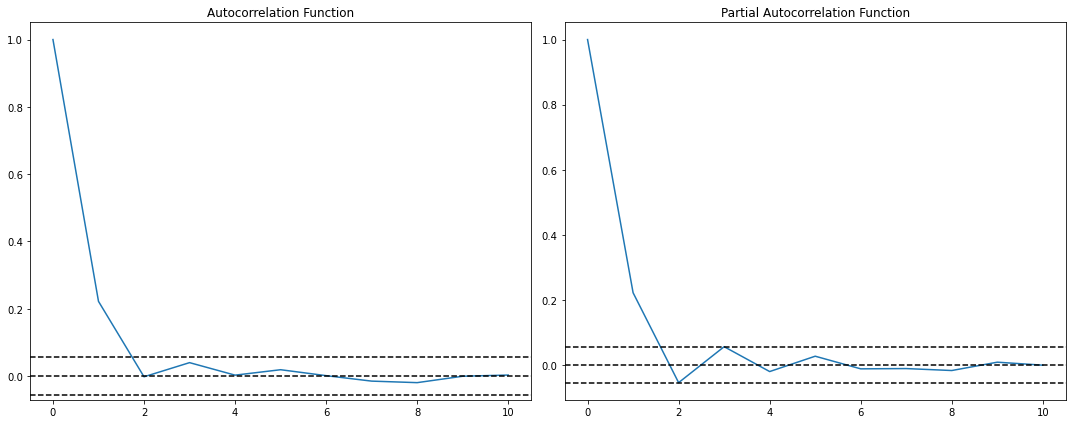

In [21]:
lag_auto_corr = acf(usd_eur_week_log_diff, nlags=10)
lag_par_auto_corr = pacf(usd_eur_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(usd_eur_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(usd_eur_week_log_diff)),linestyle='--',color='black')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_par_auto_corr)
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(usd_eur_week_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(usd_eur_week_log_diff)),linestyle='--',color='black')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


## Measure the variance between the data and the values predicted by the model

                               SARIMAX Results                                
Dep. Variable:                    USD   No. Observations:                 1248
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3897.373
Date:                Tue, 06 Dec 2022   AIC                          -7782.747
Time:                        20:13:01   BIC                          -7751.976
Sample:                    01-10-1999   HQIC                         -7771.178
                         - 12-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4222      0.312      1.354      0.176      -0.189       1.033
ar.L2          0.4384      0.242      1.809      0.070      -0.037       0.913
ar.L3         -0.0564      0.064     -0.881      0.3

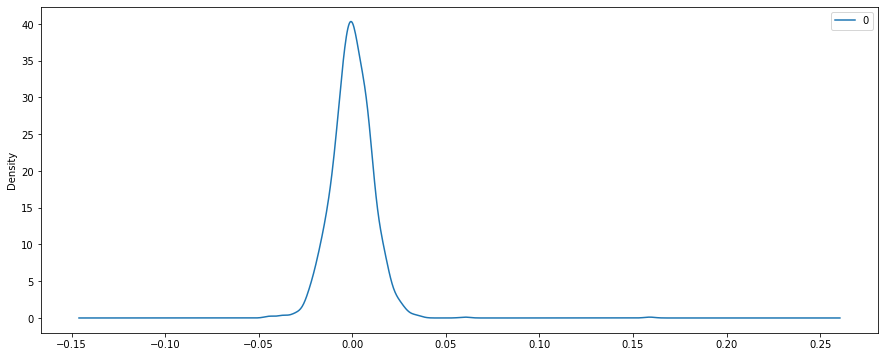

In [30]:
model = ARIMA(usd_eur_week_log, order=(3, 1, 2))  
results_ARIMA = model.fit()  
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

## Scale the model predictions back to the original scale.

In [31]:
usd_predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (usd_predictions_ARIMA_diff.head())

Date
1999-01-10    0.000000
1999-01-17    0.158934
1999-01-24    0.148449
1999-01-31    0.147208
1999-02-07    0.137439
Freq: W-SUN, dtype: float64


In [32]:
usd_predictions_ARIMA_diff_cumsum = usd_predictions_ARIMA_diff.cumsum()
usd_predictions_ARIMA_log = pd.Series(usd_eur_week_log.iloc[0], index=usd_eur_week_log.index)
usd_predictions_ARIMA_log = usd_predictions_ARIMA_log.add(usd_predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5, 1.0, 'RMSE: 1091439228578375395841257578782383946983063824019300397750989740319551716564957000949039104.0000')

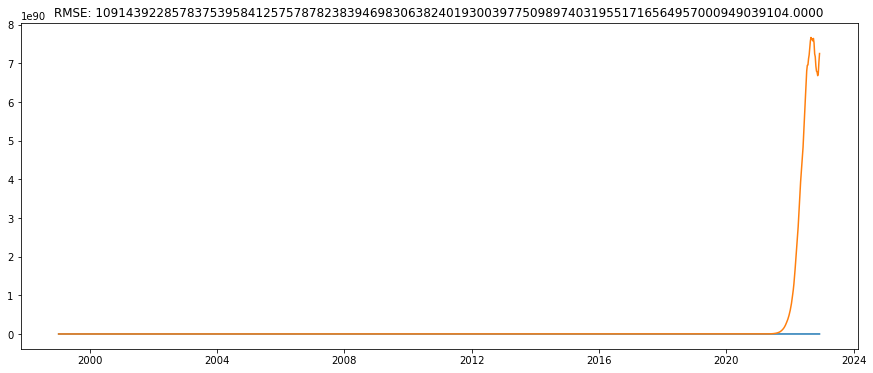

In [33]:
usd_predictions_ARIMA = np.exp(usd_predictions_ARIMA_log)
plt.plot(usd_eur_week.index.to_pydatetime(), usd_eur_week.values)
plt.plot(usd_eur_week.index.to_pydatetime(), usd_predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((usd_predictions_ARIMA-usd_eur_week)**2)/len(usd_eur_week)))